# MixSig
## Option 1
Create a model that reads a sequence of numbers, one number at a time, and classify that number based on all previously seen numbers.

## Option 2
Create a model that reads a sequence of numbers and classifies the last number in the sequence based on the previous numbers in the sequence.

## How this project is useful
 1. full control over dataset
 2. infinite dataset
 3. can study all three RNN base problems (classification, prediction, forcasting).
 

## Project Steps
 1. create dataset
 2. create network
 3. train network
 4. test network

## TODO
 - [x] create single signal generator class - A single standalone wave.
 - [x] create mixed signal generator class - Choose from one wave per timestamp.
 - [ ] create multi signal generator class - Superposition of multiple waves.
 - [x] create signal noise functions (Gaussian, etc.)
 - [x] create timestep noise functions 
 - [x] add legends to plots.
 - [ ] during training, save outlier X, y train sets to file for further analysis.
 - [x] save configuration of mixed signal properties as json.
 - [ ] make plots of the mixed signal with colors mapped to hidden layers, lstm states, etc.
 - [ ] unit tests with pytest
 - [ ] unit tests with pytest - args
 - [ ] unit tests with pytest - kwargs
 - [ ] unit tests with pytest - random generators
 - [x] create `startup.py` to handle project directories and other goodies.
 - [x] fix savefig clipping the bottoms of our figures.
 - [ ] need a function to load previous instances of a `MixedSignal`. (i.e. load values from a config.json)
 - [ ] change `MixedSignal.mixed_signal` to `MixedSignal.inputs`
 - [ ] come up with a better name for either `mixed_signal` or `mixed_wave`.
 - [ ] come up with a case with 1 input feature and 1 output class. (binary classification)
   - [ ] Where do waves from a mix sig overlap?
   - [ ] Add noise to some of the datapoints and classify whether a datapoint has been noised or not.
     - [ ] How What percentage of points to noise?
     - [ ] How much should we `noise` each point.
     - [ ] Can also add a threshold and ask. "has datapoint been noised within some delta threshold?"
 - [ ] come up with a case with 1 input feature and 2+ output classes. (categorical classification)
   - [ ] Classify the last number in the sequence based on the rest of the sequence.
 - [ ] come up with a case with 2+ input features and 1 output class. (binary classification)
   - [ ] Calculate ...
 - [ ] come up with a case with 2+ input features and 2+ output classes. (categorical classification)
   - [ ] Use the signal and derivitave of 4 different waves to make a mixed wave.
 - [ ] Move most (if not all) of this documentation into the project `README`.

## Data generator parameters to test
 1. All 4 wave variables
  - amplitude
  - frequency (period)
  - offset
  - phase
 2. sequence length
 3. signal noise
 4. timestep noise (jitter, pareto)
 5. number of signals
 6. types of signals (single, mixed, multi)

## Model hyperparameters to test
 - `n_timestamps`number of timestamps
 - `window_size` number of timesteps in sub-sequence window
 - `n_neurons` number of neurons per LSTM
 - number of LSTM recurrent cells
 - number of LSTM layers
 - `n_epochs` number of epochs
 - `batch_size`
 - `window_type` Sliding or Boxcar?
 - `stateful` True or False?

## Questions to answer
 Q: What would a batch look like?
 
 Q: How many LSTM layers do we need? nodes per LSTM layer?
 
 Q: Can we learn if our timestamps are not uniformly spaced.
 
 Q: Should we make the LSTM layers stateful?
 
 Q: Should we use sliding window or boxcar sequences?
 
 Q: For stateful LSTM's must we call `model.reset_states()` after any `model.evaluate()` and/or `model.predict()` calls? 
 
 A: **YES** Ref: Greenlee's book on LSTM's. p.49

## Notes

In [331]:
import os
import sys
import time
import json
import h5py
import random
import itertools
import numpy as np
import pandas as pd
from pandas.plotting import table

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

from IPython.display import SVG
# from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Add
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import Masking
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical

from mixsig.mixed import MixedSignal
from mixsig.mixed import SignalGenerator
from mixsig.utils import reversed_recombined_holt_winters
from mixsig.plot_utils import plot_confusion_matrix

In [ ]:
sys.path.append('/home/maddoxw/git/PhasedLSTM-Keras')
from phased_lstm_keras.PhasedLSTM import PLSTM

In [251]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [3]:
def highlight_column_matches(data, column='', color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_mixed = data == data[column]
        return [attr if v else '' for v in is_mixed]
    else:  # from .apply(axis=None)
        is_mixed = data == data[column]
        return pd.DataFrame(np.where(is_mixed, attr, ''), index=data.index, columns=data.columns)

def plot_stats(csv_filename, columns=['total_reward'], **kwargs):
    """Plot specified columns from CSV file."""
    df_stats = pd.read_csv(csv_filename)
    df_stats[columns].plot(**kwargs)

def save_rnn_layers(hidden_layers, output_layers):
    for i, layer in hidden_layers.items():
        np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_' + i + '_output'), hidden_layers[i]['output'])
        np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_' + i + '_state'), hidden_layers[i]['state'])
#     np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_2_output'), hidden_layers['2']['output'])
#     np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_2_state'), hidden_layers['2']['state'])
    np.save(os.path.join(vsig.out_dir, 'valid_output_layer'), output_layers)
    
def save_mlp_layers(hidden_layers, output_layers):
    for i, layer in hidden_layers.items():
        np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_' + i + '_output'), layer)
    np.save(os.path.join(vsig.out_dir, 'valid_output_layer'), output_layers)
    
def glance_at_tensor(tensor):
    if len(tensor.shape) == 3:
        print(tensor[:10, 0, 0])
        print(tensor[0, :10, 0])
        print(tensor[0, 0, :10])
        print('')
        print(tensor[-10:, -1, -1])
        print(tensor[-1, -10:, -1])
        print(tensor[-1, -1, -10:])
    elif len(tensor.shape) == 4:
        print(tensor[:10, 0, 0, 0])
        print(tensor[0, :10, 0, 0])
        print(tensor[0, 0, :10, 0])
        print(tensor[0, 0, 0, :10])
        print('')
        print(tensor[-10:, -1, -1, -1])
        print(tensor[-1, -10:, -1, -1])
        print(tensor[-1, -1, -10:, -1])
        print(tensor[-1, -1, -1, -10:])
        
classifier_activation = {'binary': 'sigmoid', 'categorical': 'softmax'}

## Build a signal generator

The signal generator builds waves using the standard form:

$$x(t) = A\sin\left(2\pi f t + \phi\right) + h$$

where $A$ is the amplitude (vertical scale), $f$ is the frequency (horizontal scale), $\phi$ is the phase (horizontal offset) and $h$ is the height (vertical offset). This give us fine grained control over how we construct our waves.

In [4]:
# start off with simplest case for proof of concept
wave1_coeffs = {
    'amplitude': {'mean': 0.5, 'delta': 0.05}, 
    'frequency': {'mean': 1.0, 'delta': 0.1},
    'offset': {'mean': 0.0, 'delta': 0.1}, 
    'phase': {'mean': 0.0, 'delta': 1.0},
    'name': 'A',
    'color': '#0000ff'
}
wave2_coeffs = {
    'amplitude': {'mean': 0.75, 'delta': 0.075}, 
    'frequency': {'mean': 3.0, 'delta': 0.3},
    'offset': {'mean': 0.0, 'delta': 0.1}, 
    'phase': {'mean': 0.0, 'delta': 1.0},
    'name': 'B',
    'color': '#ff0000',
#     'time': {'t_min': 0, 't_max': 5, 'n_timestamps': 601, 'noise_type': 'pareto', 'pareto_shape': 1.3},
}
wave3_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0.1}, 
    'frequency': {'mean': 8.0, 'delta': 0.8},
    'offset': {'mean': 0.0, 'delta': 0.2}, 
    'phase': {'mean': 0.0, 'delta': 1.0},
    'name': 'C',
    'color': '#00ff00'
}
wave4_coeffs = {
    'amplitude': {'mean': 1.4, 'delta': 0.1}, 
    'frequency': {'mean': 12.0, 'delta': 1.2},
    'offset': {'mean': 0.0, 'delta': 0.2}, 
    'phase': {'mean': 0.0, 'delta': 1.0},
    'name': 'D',
    'color': '#ff00ff'
}

mwave_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0}, 
    'frequency': {'mean': 1.0, 'delta': 0}, 
    'offset': {'mean': 0, 'delta': 0},
    'phase': {'mean': 0, 'delta': 1}, 
    'name': 'mixed_wave',
    'time': {'t_min': 0, 't_max': 2, 'n_timestamps': 4096, 'delta': 0}
}

sigs_coeffs = [wave1_coeffs, wave2_coeffs, wave3_coeffs, mwave_coeffs, wave4_coeffs]

features=('x', 'dxdt')[0]
batch_size = 128
window_size = 4096
window_type = 'sliding'
network_type = 'TCN'
sequence_type = 'many2many'

msig = MixedSignal(
    sigs_coeffs, 
    *features,
    window_size=window_size, 
    window_type=window_type, 
    network_type=network_type,
    sequence_type=sequence_type,
)

msig.generate()
n_classes = msig.n_classes
n_features = msig.n_features
# input_shape = (window_size, n_features) # RNN
input_shape = (None, n_features) # TCN

print(msig.inputs.shape)
print(msig.mixed_signal.shape)
print(msig.one_hots.shape)
print(msig.labels.shape)
print(msig.n_timestamps)
print(msig.n_samples)

(4096, 1)
(4096,)
(4096, 4)
(4096,)
4096
1


In [ ]:
# df = pd.DataFrame(np.vstack((msig.waves, msig.mixed_signal)).T, index=msig.timestamps, columns=['A', 'B', 'C', 'Mixed'])
waves = np.array([sig.generate(msig.timestamps) for sig in msig.waves])
df = pd.DataFrame(np.vstack((msig.timestamps, waves, msig.mixed_signal)).T, columns=['time', 'A', 'B', 'C', 'Mixed'])
df[:10].style.apply(highlight_column_matches, column='Mixed', color='lightblue', axis=1)

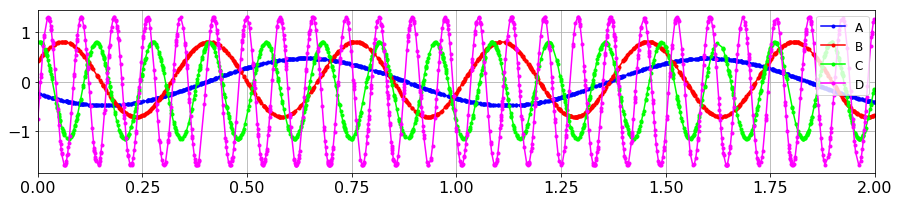

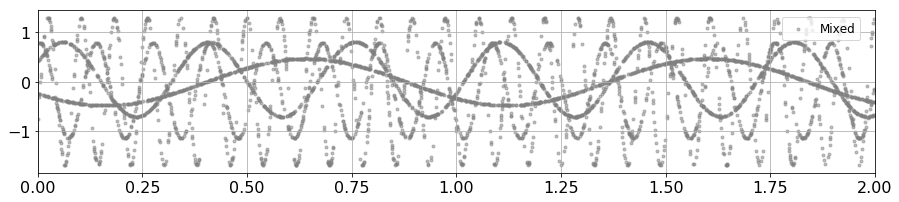

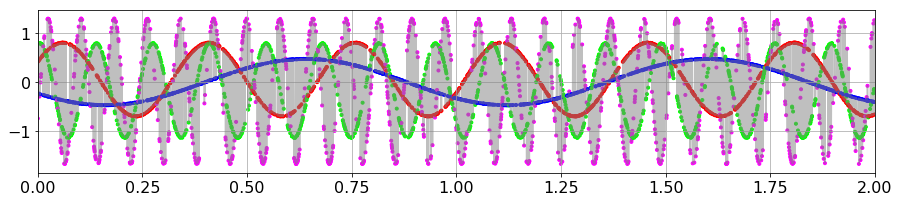

In [5]:
msig.save_config()
t_min_max = (msig.timestamps[0], msig.timestamps[-1])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
legend_labels = []
for wave in msig.waves:
    ax.plot(wave.timestamps, wave.sample, marker='.', color=wave.color)
    legend_labels.append(wave.name)
ax.set_xlim(t_min_max)
plt.grid(True)
ax.legend(legend_labels)
plt.savefig(os.path.join(msig.out_dir, 'all_waves_with_truth.png'))
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.scatter(msig.timestamps, msig.mixed_signal, color='grey', marker='.', alpha=0.5)
ax.set_xlim(t_min_max)
plt.grid(True)
ax.legend([msig.name], loc='upper right', bbox_to_anchor=(0.99, 0.99))
plt.savefig(os.path.join(msig.out_dir, 'mixed_signal.png'))
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.5)
y_test_colors = np.hstack([msig.waves[i].color for i in msig.labels])
ax.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=y_test_colors)
ax.set_xlim(t_min_max)
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'mixed_signal_with_truth.png'))
plt.show()

# Playground

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
# Generate dummy data
data = np.random.random((1000, 100))
labels = np.random.randint(2, size=(1000, 1))

# Train the model, iterating on the data in batches of 32 samples
# model.fit(data, labels, epochs=10, batch_size=32)

In [7]:
n_neurons = 32
kernel_size = 5
n_hidden = 11
stateful = False

In [ ]:
x = Input(shape=input_shape)
h1 = Dense(n_neurons, activation='relu')(x)
h2 = Dense(n_neurons, activation='relu')(h1)
z = Dense(msig.n_classes, activation='softmax')(h2)
model = Model(inputs=[x], outputs=[z])

In [ ]:
print(input_shape, 2**n_hidden)
loss = msig.classification_type + '_crossentropy'
fc_act = classifier_activation[msig.classification_type]
out_neurons = 1 if msig.classification_type == 'binary' else n_classes
conv1d_kwargs = dict(kernel_size=kernel_size, padding='causal', activation='relu')
compile_kwargs = dict(loss=loss, optimizer='adam', metrics=['accuracy'])

model = Sequential()
model.add(Conv1D(n_neurons, dilation_rate=1, input_shape=input_shape, **conv1d_kwargs))
for d in range(1, n_hidden):
    model.add(Conv1D(n_neurons, dilation_rate=2**d, **conv1d_kwargs))
model.add(Dense(out_neurons, activation=fc_act))
model.compile(**compile_kwargs)
model.summary()

In [ ]:
(model.input_shape, model.output_shape)

In [ ]:
def temporal_layer(x, n_neurons, dilation_rate, conv1d_kwargs, normalize=False, dropout=0):
    h = Conv1D(n_neurons, dilation_rate=dilation_rate, **conv1d_kwargs)(x)
    if normalize:
        h = BatchNormalization()(h)
    h = Activation('relu')(h)
    if dropout:
        h = Dropout(dropout)(h)
    return h

def temporal_block(h0, n_neurons, dilation_rate, conv1d_kwargs, normalize=False, dropout=0):
    h1 = temporal_layer(h0, n_neurons, dilation_rate, conv1d_kwargs, normalize=normalize, dropout=dropout)
    h2 = temporal_layer(h1, n_neurons, dilation_rate, conv1d_kwargs, normalize=normalize, dropout=dropout)
    res = Conv1D(n_neurons, kernel_size=1)(h0) if h0.shape != h2.shape else h0        
    block = Add()([res, h2])
    return Activation('relu')(block)

print(input_shape, 2**n_hidden)
loss = msig.classification_type + '_crossentropy'
fc_act = classifier_activation[msig.classification_type]
out_neurons = 1 if msig.classification_type == 'binary' else n_classes
conv1d_kwargs = dict(kernel_size=kernel_size, padding='causal')
compile_kwargs = dict(loss=loss, optimizer='adam', metrics=['accuracy'])

x = Input(shape=input_shape)
# h = temporal_layer(x, n_neurons, 1, conv1d_kwargs)
h = temporal_block(x, n_neurons, 1, conv1d_kwargs, normalize=False)
for d in range(1, n_hidden):
#     h = temporal_layer(h, n_neurons, 2**d, conv1d_kwargs)
    h = temporal_block(h, n_neurons, 2**d, conv1d_kwargs, normalize=False)
z = Dense(out_neurons, activation=fc_act)(h)

model = Model(inputs=[x], outputs=[z])
model.compile(**compile_kwargs)
model.summary()

In [ ]:
# define model
model = Sequential()
# model.add(Masking(mask_value=-1, input_shape=(1,)))
# model.add(LSTM(n_neurons, input_shape=(msig.window_size, 1), return_sequences=True))
# model.add(LSTM(n_neurons, input_shape=self.input_shape, return_sequences=False, dropout=0.5))
# model.add(LSTM(n_neurons, input_shape=(2, 1)))
# model.add(LSTM(n_neurons, input_shape=(window_size, 2)))
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, window_size, 1), stateful=stateful, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(window_size, 1, 1), stateful=stateful, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(window_size, 1, 1), stateful=stateful))
model.add(LSTM(n_neurons, stateful=stateful, return_sequences=True))
# model.add(LSTM(n_neurons))
# for _ in range(n_layers):
#     model.add(LSTM(n_neurons, stateful=stateful, return_sequences=True))
# model.add(LSTM(n_neurons, stateful=stateful))
# model.add(Dense(n_classes, activation='softmax'))
# model.add(Dropout(0.5))
# model.add(Reshape((n_neurons, n_classes, 1)))
model.add(TimeDistributed(Dense(n_classes, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [ ]:
x = Input(batch_shape=(batch_size, window_size, n_features))
z1 = LSTM(n_neurons, return_sequences=True, stateful=stateful)(x)
z2 = LSTM(n_neurons, return_sequences=False, stateful=stateful)(z1)
z = Dense(n_classes, activation='softmax')(z2)
# z = TimeDistributed(Dense(n_classes, activation='softmax'))(z2)

model = Model(inputs=[x], outputs=[z])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [ ]:
x = Input(batch_shape=(batch_size, window_size, 1))
z1 = PLSTM(n_neurons, return_sequences=True, implementation=2)(x)
z2 = PLSTM(n_neurons, return_sequences=True, implementation=2)(z1)
z = Dense(n_classes, activation='softmax')(z2)

model = Model(inputs=[x], outputs=[z])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [ ]:
model_config_filename = os.path.join(msig.out_dir, 'model_config.json')
model_summary_filename = os.path.join(msig.out_dir, 'model_plot.png')
with open(model_config_filename, 'w') as ofs:
    json.dump(json.loads(model.to_json()), ofs, indent=4)
plot_model(model, to_file=model_summary_filename, show_shapes=True, show_layer_names=True)

In [ ]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [11]:
# Code specific to window_type == sliding
# x_test, y_test = msig.generate_samples(1, 'xwf_xwc')
# test_dict = {
#     'sequence_type': msig.sequence_type,
#     'window_type': msig.window_type,
#     'window_size': msig.window_size,
#     'class_colors': np.hstack([wave.color for wave in msig.waves]),
#     'timestamps': msig.timestamps,
#     'X': x_test, 
#     'y': y_test, 
#     'y_hat': [],
#     'epoch': [], 
#     'score': [],
# }

In [10]:
csvlogger = CSVLogger(msig.training_stats_filename, separator=',', append=True)
checkpointer = ModelCheckpoint(msig.model_filename, save_best_only=True, save_weights_only=False, verbose=1, period=5)

In [ ]:
epochs = 200
batch_size = 128
n_samples_train = 4096
n_samples_valid = 1024
status_update_every = 20

x_valid, y_valid = msig.generate_samples(n_samples_valid, 'tf_tc')

training_generator = SignalGenerator(n_samples_train, batch_size, msig, 'tf_tc')
t0 = time.time()
model.fit_generator(
    generator=training_generator,
    validation_data=(x_valid, y_valid),
    verbose=1, 
    epochs=epochs,
    callbacks=[
        csvlogger,
        checkpointer
    ],
    use_multiprocessing=True,
    workers=4
)
if (i + 1) % status_update_every == 0:
    print('#' * 45)
    print(f'Epoch: {(i + 1)}/{epochs}, Time: {time.time() - t0}')
    print('#' * 45)
    t0 = time.time()

In [ ]:
n_samples_train = 2048
n_samples_valid = 512
epochs = 200
dump_every = 1
status_update_every = 50

x_valid, y_valid, *_ = msig.generate_samples(n_samples_valid, 'tf_tc')

for i in range(epochs):
    x_train, y_train, *_ = msig.generate_samples(n_samples_train, 'tf_tc')
    model.fit(
        x_train, y_train,
        epochs=1, 
        validation_data=(x_valid, y_valid),
        batch_size=batch_size,
        verbose=1, 
        callbacks=[
            csvlogger,
            checkpointer
        ],
    )
    if stateful:
        model.reset_states()

# Code specific to window_type == sliding

#     if (i + 1) % dump_every == 0:     
#         test_dict['epoch'].append(i + 1)
#         score = model.evaluate(test_dict['X'], test_dict['y'], batch_size=batch_size)
#         if stateful:
#             model.reset_states()
#         test_dict['score'].append(score)

#         y_hat = model.predict(test_dict['X'], batch_size=batch_size)
#         if stateful:
#             model.reset_states()
#         test_dict['y_hat'].append(y_hat)

    if (i + 1) % status_update_every == 0:
        print('#' * 50)
        print(f'Epoch: {(i + 1)}/{epochs}')
        print('#' * 50)
#         model.save(msig.model_filename)

## new test signal

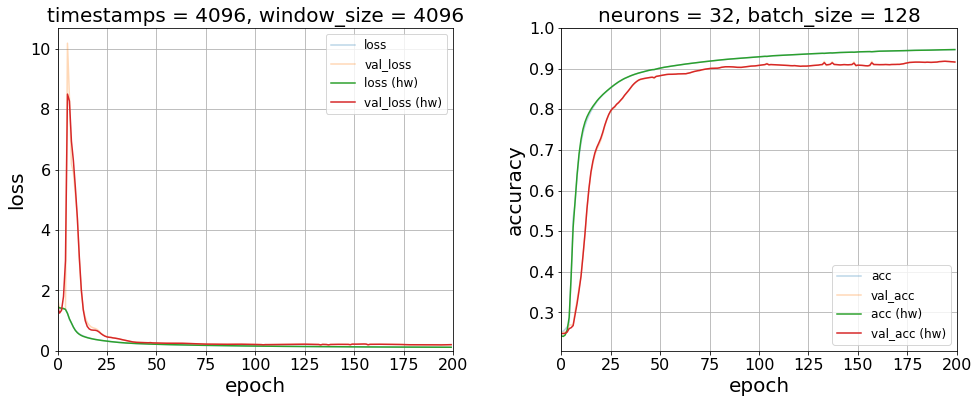

In [13]:
df_stats = pd.read_csv(msig.training_stats_filename)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# span = 111//30 = 3
span = epochs // 100

loss_dict = {
    'loss': df_stats.loss,
    'val_loss': df_stats.val_loss,
    'loss (hw)': reversed_recombined_holt_winters(np.array(df_stats.loss), span=span),
    'val_loss (hw)': reversed_recombined_holt_winters(np.array(df_stats.val_loss), span=span)

}
alphas = {
    'loss': 0.3,
    'val_loss': 0.3,
    'loss (hw)': 1,
    'val_loss (hw)': 1
}

legend_labels = []
for key, value in loss_dict.items():
    ax1.plot(value, alpha=alphas[key])
    legend_labels.append(key)

ax1.set_title(r'timestamps = {}, window_size = {}'.format(msig.n_timestamps, msig.window_size))
ax1.set_xlabel(r'epoch')
ax1.set_xlim((0, len(df_stats.acc)))
ax1.set_ylabel(r'loss')
ax1.set_ylim((0, None))
ax1.grid(True)
ax1.legend(legend_labels)

acc_dict = {
    'acc': df_stats.acc,
    'val_acc': df_stats.val_acc,
    'acc (hw)': reversed_recombined_holt_winters(np.array(df_stats.acc), span=span),
    'val_acc (hw)': reversed_recombined_holt_winters(np.array(df_stats.val_acc), span=span)

}
alphas = {
    'acc': 0.3,
    'val_acc': 0.3,
    'acc (hw)': 1,
    'val_acc (hw)': 1
}

legend_labels = []
for key, value in acc_dict.items():
    ax2.plot(value, alpha=alphas[key])
    legend_labels.append(key)

ax2.set_title(r'neurons = {}, batch_size = {}'.format(n_neurons, batch_size))
ax2.set_xlabel(r'epoch')
ax2.set_xlim((0, len(df_stats.acc)))
ax2.set_ylabel(r'accuracy')
ax2.set_ylim((None, 1))
ax2.grid(True)
ax2.legend(legend_labels)

plt.tight_layout()
plt.savefig(os.path.join(msig.out_dir, 'loss_accuracy.png'))
plt.show()

In [160]:
x_test, y_test = msig.generate(sequence_code='1tf_1tc')
epoch = 0
score = model.evaluate(x_test, y_test, batch_size=batch_size)
# if stateful:
#     model.reset_states()
y_hat = model.predict(x_test, batch_size=batch_size)
# if stateful:
#     model.reset_states()

# Code specific to window_type == sliding
# ii = 100
# x_test = test_dict['X']
# y_test = test_dict['y']
# score = test_dict['score'][ii]
# epoch = test_dict['epoch'][ii]
# y_hat = test_dict['y_hat'][ii]
# x_test_clipped = x_test[:, test_dict['window_size'] - 1:, 0]

y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(y_hat, axis=-1)

y_correct = (y_pred == y_true) * 1
y_fail = (y_pred != y_true) * 1

print('x_test  {}'.format(x_test.shape))
print('y_test  {}'.format(y_test.shape))
print('y_true  {}'.format(y_true.shape))
print(score)
print('y_hat   {}'.format(y_hat.shape))
print('y_pred  {}'.format(y_pred.shape))

print(y_hat[0, :4])
print(y_true[0, :10])
print(y_pred[0, :10])
print(y_fail[0, :10])

i_fail = np.where(y_fail)[1]
print(i_fail.shape)
# print(i_fail)

# y_true_colors = np.hstack([msig.waves[i].color for i in y_true])    
# y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred])
y_true_colors = np.hstack([msig.waves[i].color for i in y_true[0]])
y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred[0]])
# y_true_colors = [msig.waves[i[-1]].color for i in y_true[0]]
# y_pred_colors = [msig.waves[i[-1]].color for i in y_pred[0]]

print('y_pred_colors {}'.format(y_pred_colors.shape))
# print(msig.timestamps.shape)


# Code specific to window_type == sliding

# I derived y_score based on my intuition (i.e. out of thin air).  Would be nice to find some theoretical justification for why this is I like it so much.
# if msig.sequence_type == 'many2many':
#     y_true_value = [y_hat[i, j, y_true[i, j]] for i in range(y_true.shape[0]) for j in range(y_true.shape[1])]
#     y_pred_value = [y_hat[i, j, y_pred[i, j]] for i in range(y_pred.shape[0]) for j in range(y_pred.shape[1])]
#     y_true_value = np.reshape(y_true_value, y_true.shape)
#     y_pred_value = np.reshape(y_pred_value, y_pred.shape)
#     y_penalty = y_true_value - y_pred_value
#     y_score = y_true_value + y_penalty
# else:
#     y_true_value = y_hat[(np.arange(y_true.shape[0]), y_true[0])]
#     y_pred_value = y_hat[(np.arange(y_pred.shape[0]), y_pred[0])]
#     y_penalty = y_true_value - y_pred_value
#     y_score = y_true_value + y_penalty
    # Hack: Make y_score the same shape as many2many y_score
#     y_score = y_score[:, None] * np.ones((msig.window_size,))[None, :]
# print(y_true_value.shape)
# print(y_pred_value.shape)
# print(y_penalty.shape)
# print(y_score.shape)

1/1 [==============================] - 0s 27ms/step
x_test  (1, 4096, 1)
y_test  (1, 4096, 4)
y_true  (1, 4096)
[0.15375825762748718, 0.929443359375]
y_hat   (1, 4096, 4)
y_pred  (1, 4096)
y_colors(4096,)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)


In [ ]:
# Code specific to window_type == sliding
# print(y_true_colors[:4])
# print(test_dict['class_colors'][y_true][:4])
# test_dict['sequence_type']

In [84]:
# Code specific to window_type == sliding

# j = 10
# s0 = slice(0, j)
# s1 = slice(-j, -1)
# s0 = s1
# print(y_hat[s0, s1])
# print(y_true[s0, s1])
# print(y_true_value[s0, s1])
# print(y_pred[s0, s1])
# print(y_pred_value[s0, s1])
# print(y_penalty[s0, s1])
# print(y_score[s0, s1])
# print(np.min(y_score), np.max(y_score))

if msig.sequence_type == 'many2many':
    y_score_mean = y_score.sum(axis=1) / y_score.shape[1]
    y_score_unshifted = np.zeros((msig.n_timestamps, msig.window_size))
    for i in range(msig.window_size):
        y_score_unshifted[i:i + msig.n_samples, i] = y_score[:, i]
    y_score_unshifted_clipped = y_score_unshifted[msig.window_size-1:]
    y_score_unshifted_clipped_mean = y_score_unshifted_clipped.sum(axis=1) / y_score.shape[1]
else:
    y_score_mean = y_score.sum(axis=1) / y_score.shape[1]
    y_score_unshifted = np.zeros((msig.n_timestamps, msig.window_size))
    for i in range(msig.window_size):
        y_score_unshifted[i:i + msig.n_samples, i] = y_score[:, i]
    y_score_unshifted_clipped = y_score_unshifted[msig.window_size-1:]
    y_score_unshifted_clipped_mean = y_score_unshifted_clipped.sum(axis=1) / y_score.shape[1]

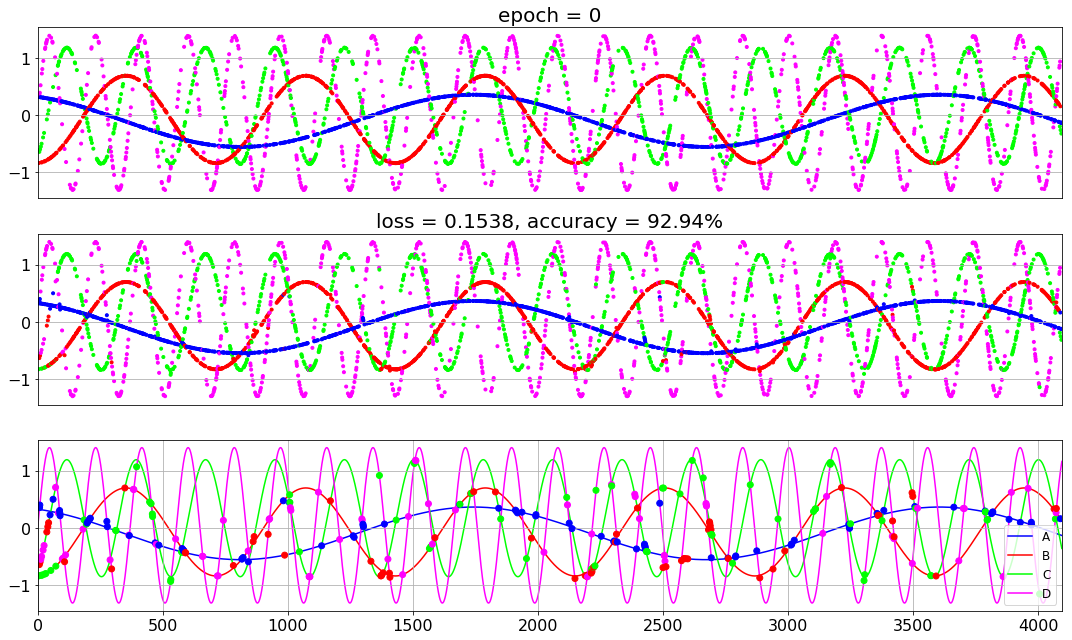

In [400]:
xmin = 0
xmax = x_test.shape[1]
xindex = np.arange(xmin, xmax)
nrows=3
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 3*nrows))

ax[0].scatter(
    xindex, 
    x_test[0, :, 0], 
    marker='.', 
    c=y_true_colors)
ax[0].set_title('epoch = {}'.format(epoch))
ax[0].set_xlim((xmin, xmax))
ax[0].set_xticks([])
ax[0].grid(True)

ax[1].scatter(
    xindex, 
    x_test[0, :, 0], 
    marker='.', 
    c=y_pred_colors)
ax[1].set_title('loss = {:<6.4f}, accuracy = {:<.2%}'.format(*score))
ax[1].set_xlim((xmin, xmax))
ax[1].set_xticks([])
ax[1].grid(True)

legend_labels = []
for wave in msig.waves:
    ax[2].plot(
        xindex,
        wave.sample_full, 
        color=wave.color,
        zorder=1)
    legend_labels.append(wave.name)

ax[2].scatter(
    xindex[i_fail], 
    x_test[0, i_fail, 0], 
    marker='o', 
    c=y_pred_colors[i_fail],
    zorder=2)

ax[2].set_xlim((xmin, xmax))
ax[2].grid(True)
ax[2].legend(legend_labels)

# plt.draw()
plt.tight_layout()
plt.savefig(os.path.join(msig.out_dir, 'prediction_analysis.png'), bbox_inches='tight')
# plt.show()

In [369]:
waves_nearest_neighbor = []
waves = np.array([w.sample_full for w in msig.waves])
for i, wi in enumerate(msig.waves):
    waves_diff_all = np.abs(wi.sample_full - waves)
    waves_diff = np.delete(waves_diff_all, i, axis=0)
    waves_nearest_neighbor.append(np.min(waves_diff, axis=0))
waves_nearest_neighbor = np.vstack(waves_nearest_neighbor)
print(waves_nearest_neighbor.shape)

(4, 4096)


In [ ]:
print(np.min(waves_nearest_neighbor))
print(np.max(waves_nearest_neighbor))
print(waves_nearest_neighbor[:,20:25])

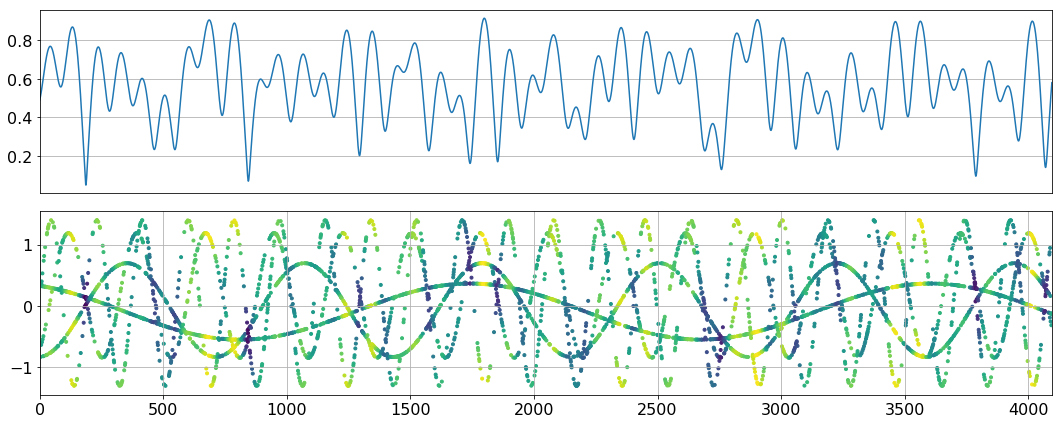

In [391]:
waves_std = np.std(waves, axis=0)
i_std = np.where(waves_std < 0.32245)[0]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

ax[0].plot(xindex, waves_std)
ax[0].set_xlim((xmin, xmax))
ax[0].set_xticks([])
ax[0].grid(True)

ax[1].scatter(
    xindex, 
    x_test[0, :, 0], 
    marker='.', 
    c=waves_std)
ax[1].set_xlim((xmin, xmax))
ax[1].grid(True)
plt.tight_layout()
plt.savefig(os.path.join(msig.out_dir, 'std_dev_analysis.png'), bbox_inches='tight')

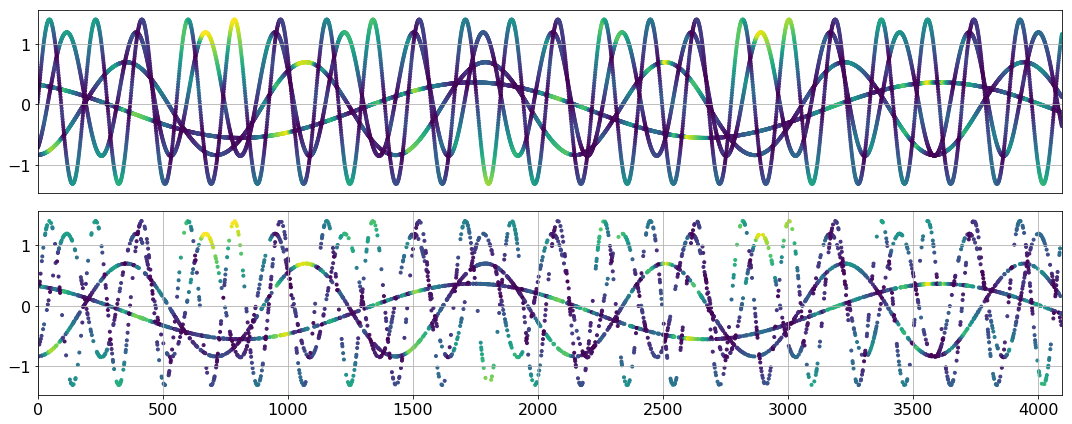

In [392]:
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 3*nrows))

for i, wave in enumerate(msig.waves):
    ax[0].scatter(
        xindex,
        wave.sample_full, 
        marker='.', 
        c=waves_nearest_neighbor[i]
    )
ax[0].set_xlim((xmin, xmax))
ax[0].set_xticks([])
ax[0].grid(True)

for i, wave in enumerate(msig.waves):
    ax[1].scatter(
        xindex[wave.indices],
        wave.sample, 
        marker='.', 
        c=waves_nearest_neighbor[i, wave.indices]
    )
ax[1].set_xlim((xmin, xmax))
ax[1].grid(True)
plt.tight_layout()
plt.savefig(os.path.join(msig.out_dir, 'nearest_neighbor_analysis.png'), bbox_inches='tight')

In [396]:
i_maxmin = np.argmax(waves_nearest_neighbor, axis=0)
wave_max_distance = np.max(waves_nearest_neighbor, axis=0)
wave_farthest_neighbor_colors = [0] * len(xindex)
wave_farthest_neighbor = np.zeros((len(xindex),))
for i, ii in enumerate(i_maxmin):
    wave_farthest_neighbor_colors[i] = msig.waves[ii].color
    wave_farthest_neighbor[i] = msig.waves[ii].sample_full[i]
transition_vlines = np.where(i_maxmin[1:] - i_maxmin[:-1])[0] + 1
transition_vcolors = [wave_farthest_neighbor_colors[v] for v in transition_vlines]

w_size = 17
center = (w_size - 1) // 2
min_peaks_vlines = []
for i in range(len(xindex) - w_size):
    if np.argmin(wave_max_distance[i:i + w_size]) == center:
        min_peaks_vlines.append(i + center)

min_peaks_vlines = np.array(min_peaks_vlines)
# print(min_peaks_vlines[1:] - min_peaks_vlines[:-1])
# print(min_peaks_vlines)
min_peaks_vcolors = np.array([wave_max_distance[v] for v in min_peaks_vlines])
min_peaks_vcolors /= np.max(min_peaks_vcolors)
# print(len(min_peaks_vcolors))
# print(min_peaks_vcolors)

vmin = 0
vmax = 0.65
cmap = cm.Greys_r

# alphas = np.ones(wave_max_distance.shape) * 0.2
wave_max_distance_colors = Normalize(vmin, vmax, clip=True)(wave_max_distance)
wave_max_distance_colors = cmap(wave_max_distance_colors)
# wave_max_distance_colors[..., -1] = alphas

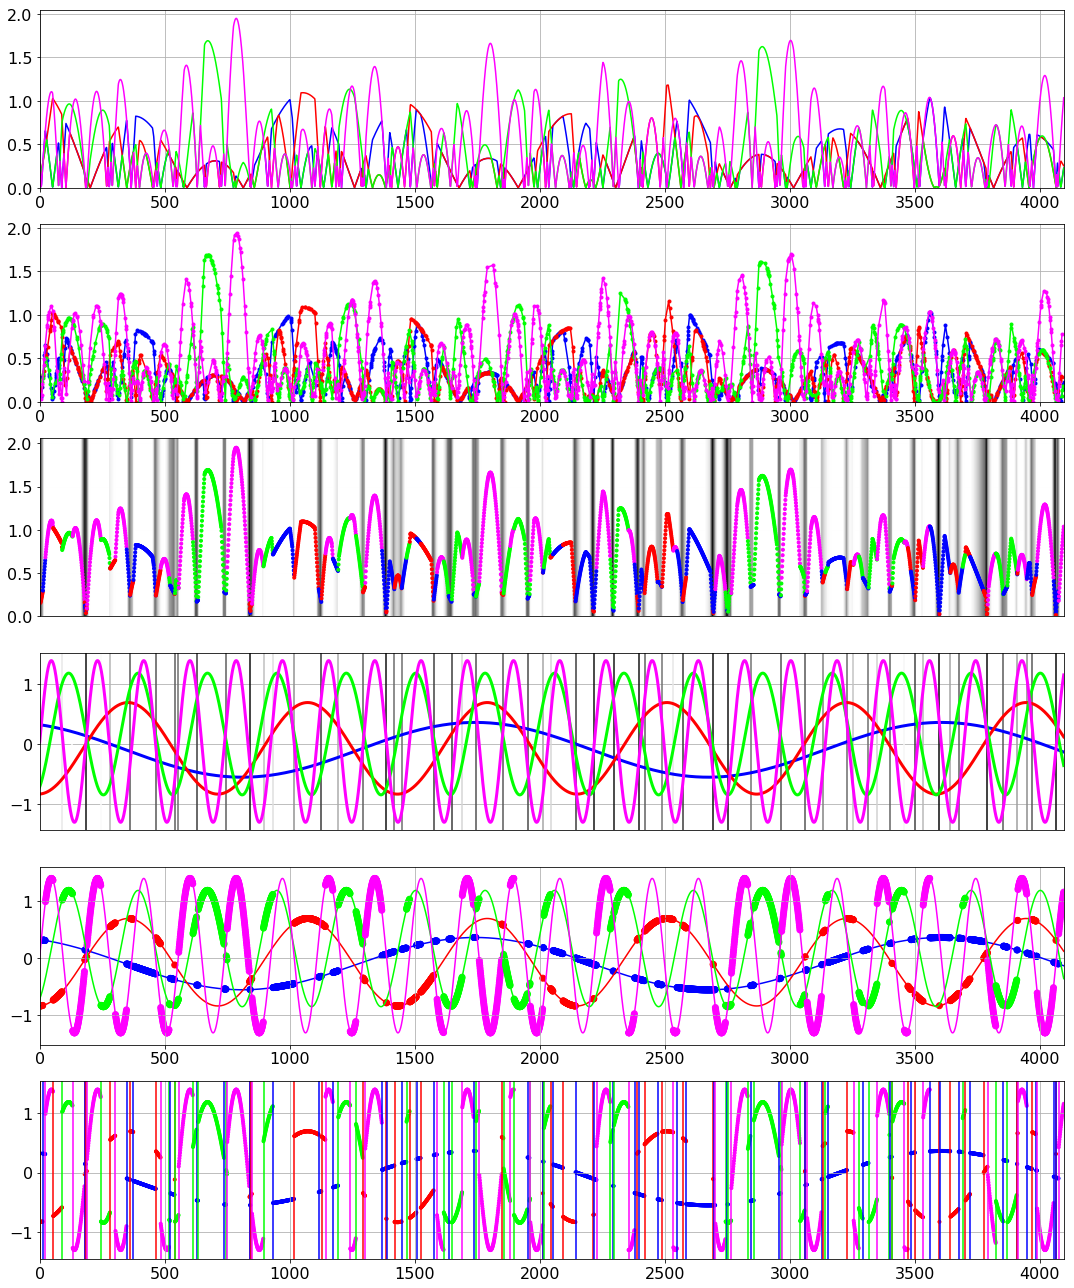

In [398]:
nrows = 6
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 3*nrows))

for i, wave in enumerate(msig.waves):
    ax[0].plot(
        xindex,
        waves_nearest_neighbor[i], 
        c=wave.color)
ax[0].set_xlim((xmin, xmax))
ax[0].set_ylim((0, None))
ax[0].grid(True)

for i, wave in enumerate(msig.waves):
    ax[1].plot(
        xindex[wave.indices],
        waves_nearest_neighbor[i, wave.indices], 
        marker='.', 
        c=wave.color)
ax[1].set_xlim((xmin, xmax))
# ax[1].set_xticks([])
ax[1].set_ylim((0, None))
ax[1].grid(True)

ax[2].vlines(xindex, 0, 1, transform=ax[2].get_xaxis_transform(), colors=wave_max_distance_colors)
ax[2].scatter(
    xindex,
    wave_max_distance, 
    marker='.', 
    c=wave_farthest_neighbor_colors,
    zorder=2)
ax[2].set_xlim((xmin, xmax))
ax[2].set_xticks([])
ax[2].set_ylim((0, None))
ax[2].grid(True)

for wave in msig.waves:
    ax[3].plot(
        xindex,
        wave.sample_full, 
        color=wave.color, 
        lw=3)
ax[3].vlines(min_peaks_vlines, 0, 1, transform=ax[3].get_xaxis_transform(), colors=cmap(min_peaks_vcolors))
# ax[3].vlines(xindex, 0, 1, transform=ax[3].get_xaxis_transform(), colors=wave_max_distance_colors)
ax[3].set_xlim((xmin, xmax))
ax[3].set_xticks([])
ax[3].grid(True)

for wave in msig.waves:
    ax[4].plot(
        xindex,
        wave.sample_full, 
        color=wave.color)
ax[4].scatter(
    xindex, 
    wave_farthest_neighbor, 
    marker='o', 
    c=wave_farthest_neighbor_colors)
ax[4].set_xlim((xmin, xmax))
# ax[4].set_xticks([])
ax[4].grid(True)

ax[5].scatter(
    xindex, 
    wave_farthest_neighbor, 
    marker='.', 
    c=wave_farthest_neighbor_colors)
ax[5].vlines(transition_vlines, 0, 1, transform=ax[5].get_xaxis_transform(), colors=transition_vcolors)
ax[5].set_xlim((xmin, xmax))
ax[5].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(msig.out_dir, 'farthest_neighbor_analysis.png'), bbox_inches='tight')

In [ ]:
# Code specific to window_type == sliding

xmin = 0
xmax = y_score.shape[0]
xindex = range(xmin, xmax)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 16))
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)

ax[0].scatter(
    xindex, 
    x_test_clipped, 
    marker='.', 
    c=y_true_colors)
ax[0].set_title('epoch = {}'.format(epoch))
ax[0].set_xlim((xmin, xmax))
ax[0].set_xticks([])
ax[0].grid(True)

ax[1].imshow(
    y_score.T, 
    interpolation='nearest', 
    cmap=plt.get_cmap('Spectral'), 
    origin='upper');
ax[1].spines['top'].set_visible(False)
ax[1].set_xlim((xmin, xmax))
ax[1].set_xticks([])
ax[1].set_ylim((y_score.shape[1], 0))
ax[1].set_yticks([y_score.shape[1]])

divider = make_axes_locatable(ax[1])
ax1Top = divider.append_axes("top", 0.5, sharex=ax[1])
ax1Top.xaxis.set_tick_params(labelbottom=False)
ax1Top.plot(y_score_mean)
ax1Top.set_title('sequence model type = {}'.format(msig.sequence_type))
ax1Top.set_xlim((xmin, xmax))
ax1Top.set_ylim((-1, 1))
ax1Top.set_yticks((-1, 0, 1))
ax1Top.grid(True)

ax[2].imshow(
    y_score_unshifted_clipped.T, 
    interpolation='nearest', 
    cmap=plt.get_cmap('Spectral'), 
    origin='upper');
ax[2].spines['top'].set_visible(False)
ax[2].set_xlim((xmin, xmax))
ax[2].set_xticks([])
ax[2].set_ylim((y_score_unshifted_clipped.shape[1], 0))
ax[2].set_yticks([y_score_unshifted_clipped.shape[1]])

divider = make_axes_locatable(ax[2])
ax2Top = divider.append_axes("top", 0.5, sharex=ax[2])
ax2Top.xaxis.set_tick_params(labelbottom=False)
ax2Top.plot(y_score_unshifted_clipped_mean)
ax2Top.set_title('{} window size = {}'.format(window_type, msig.window_size))
ax2Top.set_xlim((xmin, xmax))
ax2Top.set_ylim((-1, 1))
ax2Top.set_yticks((-1, 0, 1))
ax2Top.grid(True)

ax[3].scatter(
    xindex, 
    x_test_clipped,
    marker='.', 
    c=y_pred_colors)
ax[3].set_title('loss = {:<6.4f}, accuracy = {:<.2%}'.format(*score))
ax[3].set_xlim((xmin, xmax))
ax[3].grid(True)

# plt.draw()
plt.savefig(os.path.join(msig.out_dir, 'prediction_analysis.png'), bbox_inches='tight', pad_inches=0.08)
# plt.show()

In [ ]:
if msig.sequence_type == 'many2many':
    plot_confusion_matrix(y_true[:, -1], y_pred[:, -1], figsize=(8, 6), filename=os.path.join(msig.out_dir, 'confusion_matrix.png'))
else:
    plot_confusion_matrix(y_true[0], y_pred[0], figsize=(8, 6), filename=os.path.join(msig.out_dir, 'confusion_matrix.png'))

In [ ]:
import importlib

In [ ]:
importlib.reload(plot_utils);

In [ ]:
import mixsig.plot_utils as plot_utils

In [ ]:
plot_utils.plot_prediction_tests(test_dict, os.path.join(msig.out_dir, 'training_snapshots'))

Now browse to the training_snapshots folder and run,
```bash
ffmpeg -framerate 30 -i %05d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ../prediction_analysis.mp4
```

In [ ]:
from mixsig.utils import factors
# CODE
# fact_a = factors(self.batch_size)
# fact_b = factors(self.window_size)
# gcm = max(fact_a.intersection(fact_b))
# chop_index = len(timestamps) % (self.window_size * self.batch_size // gcm)

# TODO: Move this to unit tests
ws, bs = 512, 392
nts = 200771
print(f'nts   = {nts}\nws*bs = {ws * bs}')
print(factors(nts))

fact_a = factors(bs)
print(fact_a)
fact_b = factors(ws)
print(fact_b)
gcm = max(fact_a.intersection(fact_b))
print(gcm)

print('#'*20)
print(ws * bs // gcm)
print(nts % (ws * bs // gcm))
nts2 = nts - (nts % (ws * bs // gcm))
print(nts2, nts2 // bs, nts2 // ws)

print('#'*20)
print(ws * bs)
print(nts % (ws * bs))
nts2 = nts - (nts % (ws * bs))
print(nts2, nts2 // bs, nts2 // ws)

In [ ]:
fig = plt.figure(figsize=(5, 3))
plt.plot(y_score.sum(axis=0) / y_score.shape[0])
plt.xlim((0, y_score.shape[1]))
plt.xlabel('timestep')
plt.ylim((0, 1))
plt.ylabel('classifier score')
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'mean_accuracy_vs_timestep.png'))

## current validation signal

In [ ]:
print(x_val.shape)
print(hidden_layers['1'].shape)
print(output_layers.shape)
print(y_val.shape)

In [ ]:
print(x_val.shape)
print(hidden_layers['1']['output'].shape)
print(hidden_layers['1']['state'].shape)
print(z1_layers.shape)
print(output_layers.shape)
print(y_val.shape)

In [ ]:
arr = np.reshape(z2_layers[..., 5], (1000, 1000))
fig = plt.figure(figsize=(14, 8))

ax = plt.subplot(111)
im = ax.imshow(arr, interpolation="none")

plt.tight_layout()
# plt.savefig(os.path.join(msig.out_dir, 'gen_loss_acc.png'))
# plt.show()

In [ ]:
layer = '1'
o_or_s = 'output'
val_arrays = np.load(os.path.join(vsig.out_dir, '_'.join(['valid_hidden_layer', layer, o_or_s])) + '.npy')
print(val_arrays.shape)
glance_at_tensor(val_arrays)

In [ ]:
out_dir = '/home/maddoxw/PycharmProjects/MixSig/out/2018-04-09_04-53-12'

In [ ]:
val_arrays = np.load(os.path.join(vsig.out_dir, 'valid_output_layer.npy'))
print(val_arrays.shape)
glance_at_tensor(val_arrays)

In [ ]:
score = model.evaluate(x_val, y_val, batch_size=batch_size)
model.reset_states()
y_hat = model.predict(x_val, batch_size=batch_size)
model.reset_states()

In [ ]:
# y_pred = np.argmax(states['y_hat'], axis=1)
# y_pred_colors = np.hstack([vsig.signal_colors[i] for i in y_pred])
t_min_max = (vsig.timestamps[0], vsig.timestamps[-1])
layer = '1'
val_arrays = np.load(os.path.join(vsig.out_dir, 'valid_hidden_layer_' + layer + '_output.npy'))
n_generations, _, n_neurons = val_arrays.shape
ncols = 1
nrows = n_neurons // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for g in range(n_generations):
    for i in range(n_neurons):
        ax = axes#[i // ncols, i % ncols]
        ax.cla()
        y_pred_colors = val_arrays[g, :, i]
        ax.plot(vsig.timestamps, vsig.mixed_signal, color='grey', alpha=0.3)
        ax.scatter(
            vsig.timestamps[vsig.window_size-1:], 
#             vsig.timestamps, 
#             x_val[:, -1, 0], 
#             x_val[0, :, 0], 
            vsig.mixed_signal[vsig.window_size-1:], 
            marker='o', 
            c=y_pred_colors, 
            cmap=plt.get_cmap('coolwarm'), 
            vmin=-1, 
            vmax=1
        )
        ax.set_title('neuron = {}'.format(i + 1))
        ax.set_xlim(t_min_max)
        ax.grid(True)
        
    plt.tight_layout()
    plt.suptitle('hidden layer = {}, ({}), generation = {}'.format(layer, 'output', g + 1))
#     plt.savefig(os.path.join(vsig.out_dir, '_'.join(['valid_hidden_layer', layer, 'gen', str(g + 1)]) + '.png'))

plt.show()

In [ ]:
# y_pred = np.argmax(states['y_hat'], axis=1)
# y_pred_colors = np.hstack([vsig.signal_colors[i] for i in y_pred])
t_min_max = (vsig.timestamps[0], vsig.timestamps[-1])
layer = '2'
o_or_s = 'output'
val_arrays = np.load(os.path.join(vsig.out_dir, '_'.join(['valid_hidden_layer', layer, o_or_s])) + '.npy')
n_generations, _, n_neurons = val_arrays.shape
ncols = 2
nrows = n_neurons // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20))

for g in range(n_generations):
    for i in range(n_neurons):
        ax = axes[i // ncols, i % ncols]
        ax.cla()
        y_pred_colors = val_arrays[g, :, i]
        ax.plot(vsig.timestamps, vsig.mixed_signal, color='grey', alpha=0.3)
        ax.scatter(
#             vsig.timestamps[vsig.window_size-1:], 
            vsig.timestamps, 
#             x_val[:, -1, 0], 
            x_val[0, :, 0], 
            vsig.timestamps[vsig.window_size-1:], 
            marker='o', 
            c=y_pred_colors, 
            cmap=plt.get_cmap('coolwarm'), 
            vmin=-1, 
            vmax=1
        )
        ax.set_title('neuron = {}'.format(i + 1))
        ax.set_xlim(t_min_max)
        ax.grid(True)
        
    plt.tight_layout()
    plt.suptitle('hidden layer = {}, ({}), generation = {}'.format(layer, o_or_s, g + 1))
    plt.savefig(os.path.join(vsig.out_dir, '_'.join(['valid_hidden_layer', layer, o_or_s, 'gen', str(g + 1)]) + '.png'))

plt.show()

In [ ]:
x_test, y_test = msig.generate()
y_hat, *args = model2.predict(x_test, batch_size=batch_size)
model2.reset_states()
y_pred = np.argmax(y_hat, axis=-1)
print('x_test', x_test.shape, '{:>9.4f} {:>9.4f}'.format(np.min(x_test), np.max(x_test)))
print('y_test', y_test.shape)
print('y_hat ', y_hat.shape, '{:>9.4f} {:>9.4f}'.format(np.min(y_hat), np.max(y_hat)))
print('y_pred', y_pred.shape, '{} {}'.format(np.min(y_pred), np.max(y_pred)))
for i, arg in enumerate(args):
    print(i, arg.shape, '{:>9.4f} {:>9.4f}'.format(np.min(arg), np.max(arg)))

In [ ]:
t_min_max = (msig.timestamps[0], msig.timestamps[-1])
y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred])
print(y_pred_colors[:3])
print(y_pred.shape, y_pred_colors.shape)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
# ax.scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_pred_colors)
# ax.scatter(msig.timestamps, x_test[0, :, 0], marker='.', c=y_pred_colors)
ax.scatter(msig.timestamps[msig.window_size-1:], msig.mixed_signal[msig.window_size-1:], marker='.', c=y_pred_colors)
ax.set_xlabel('time')
ax.set_xlim(t_min_max)
plt.grid(True)
plt.show()

In [ ]:
t_min_max = (msig.timestamps[0], msig.timestamps[-1])
x_test, y_test = msig.generate()
score = model.evaluate(x_test, y_test, batch_size=batch_size)
model.reset_states()
y_hat = model.predict(x_test, batch_size=batch_size)
model.reset_states()
y_pred = np.argmax(y_hat, axis=1)
# y_pred_colors = [msig.waves[i].color for i in msig.labels[msig.window_size-1:]]
y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax.scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_pred_colors)
ax.set_title('loss = {:<6.4f}, accuracy = {:<6.4f}'.format(*score))
ax.set_xlabel('time')
ax.set_xlim(t_min_max)
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'eval_pred.png'))
plt.show()

In [ ]:
t_min_max = (msig.timestamps[0], msig.timestamps[-1])
x_test, y_test = msig.generate()
print(x_test.shape)
print(y_test.shape)

score = model.evaluate(x_test, y_test, batch_size=batch_size)
model.reset_states()
print(score)

y_hat = model.predict(x_test, batch_size=batch_size)
y_pred = np.argmax(y_hat, axis=1)
# y_error = 1.0 - np.max(y_hat, axis=1)
model.reset_states()
# print(y_hat.shape)
print(y_pred.shape)
# print(y_error.shape)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

ax[0].plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax[0].scatter(msig.timestamps, msig.mixed_signal, marker='.')
ax[0].set_title('loss = {:<6.4f}, accuracy = {:<6.4f}'.format(*score))
ax[0].set_xlim(t_min_max)

ax[1].plot(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
ax[1].scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_pred)
ax[1].set_xlim(t_min_max)
ax[1].set_xlabel('time')
plt.show()

# Transfer weights to new model

In [ ]:
n_batch = 1
print(X.shape)
print(n_batch)
# re-define model
new_model = Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
new_model.add(LSTM(n_neurons))
new_model.add(Dense(msig.n_classes, activation='softmax'))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)
new_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

x_test, y_test = msig.generate()
score = new_model.evaluate(x_test, y_test, batch_size=n_batch)
print(score)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.one_hots)
plt.show()

In [ ]:
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
for i in range(len(x_test)):
    print('Expected', y_test[i], 'Predicted', y_hat[i])

In [ ]:
x_test, y_test = msig()
print(x_test.shape)
print(y_test.shape)
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
print(y_hat.shape)
y_pred = np.argmax(y_hat, axis=1)
print(y_pred.shape)
y_error = np.max(y_hat, axis=1)
print(y_error.shape)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_pred)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_error)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[-msig.n_samples:], y_error, color='grey', alpha=0.3)
plt.scatter(msig.timestamps[-msig.n_samples:], y_error, marker='.', c=y_error)
plt.show()